In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

# Experimental setup

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from src import models
from src import experimental_setup

from sklearn.preprocessing import StandardScaler
import multiprocessing

sn_mordred = models.SN_Mordred
sampling_type = 'random'

kfold = experimental_setup.CrossValidator(
    splits = 5, # dont change without re-running data preprocessing
    sampling_type = sampling_type
)

converter = experimental_setup.LD50UnitConverter()

In [3]:
from tensorflow.keras import backend as K

def calibrated_coverage(y_true, y_pred, tau):
    return np.mean(y_pred[:,1] >= tau)

def calibrated_empirical_risk(y_true, y_pred, tau):
    loss = (y_true[:,0] - y_pred[:,0])**2

    mse = np.mean(loss * (y_pred[:,1] >= tau).astype(np.float))

    emp_risk_num = mse
    emp_risk_denom = calibrated_coverage(y_true, y_pred, tau)

    return emp_risk_num / emp_risk_denom

# Calibration

,mean,std
,calib_empirical_risk,calib_empirical_risk
coverage,,
0.5,0.189376,0.025041
0.6,0.204021,0.007547
0.7,0.213844,0.014112
0.8,0.229291,0.005346
0.9,0.246512,0.009937
1.0,0.276780,0.014020


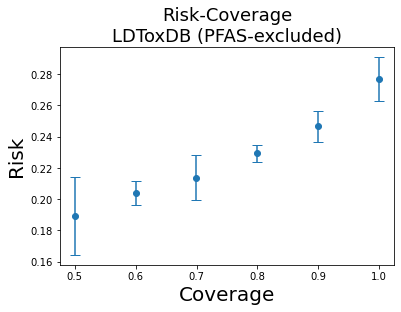

In [13]:
import matplotlib.pyplot as plt

def std(x):
    return np.std(x, ddof=1)

summary = calibration_results.pivot_table(index='coverage',aggfunc=[np.mean,std])

plt.errorbar(summary['mean']['calib_coverage'],
             summary['mean']['calib_empirical_risk'],
             yerr=summary['std']['calib_empirical_risk'], fmt='o', capsize=5)
plt.xlabel('Coverage', fontsize=20)
plt.ylabel('Risk', fontsize=20)
plt.title('Risk-Coverage\nLDToxDB (PFAS-excluded)', fontsize=18)

summary[[('mean','calib_empirical_risk'), ('std','calib_empirical_risk')]]

# Implementation + Transfer learning

In [4]:
c = 0.6

def fit_base_model(fold_no, train, test, fold_no2, train_all, test_all):
    print('Fitting base model %d' % fold_no)
    
    scaler = StandardScaler()
    scaler2 = StandardScaler()
    
    x_train, y_train, smiles_train = train
    x_test, y_test, smiles_test = test
    x_train_all, y_train_all, smiles_train_all = train_all
    
    scaler.fit(y_train_all)
    y_train = scaler.transform(y_train)
    
    scaler2.fit(x_train_all)
    x_train = scaler2.transform(x_train)
    x_test = scaler2.transform(x_test)

    # Base model
    # - Save model checkpoint
    # - Save results for LDToxDB
    model = sn_mordred(input_shape=x_train[0].shape)
    model.c_coverage = c
    model.epochs = 1000
    model.fit(x_train, y_train, verbose=0)
    
    y_hat = model.predict(x_test)[0]
    y_hat[:,0] = scaler.inverse_transform(y_hat[:,0])
    
    tau = np.percentile(y_hat[:,1], 100*(1-c))
    
    results = pd.DataFrame({
        'smiles': smiles_test.flatten(),
        'prediction_neglogld50': y_hat[:,0].flatten(),
        'prediction_raw_g': y_hat[:,1].flatten(),
        'actual_neglogld50': y_test.flatten()
    })
    
    results['prediction_selected'] = results['prediction_raw_g'] >= tau
    results.loc[~results.prediction_selected, 'prediction_neglogld50'] = None
    
    fn = 'sn_mordred_revised' + str(fold_no)
    results.to_csv('../data/selective-net/%s_predictions.csv' % fn)
    model.save_weights('../data/selective-net/chkpt/%s.chkpt' % fn)
    
    print('Completed fitting base model %d' % fold_no)


   
##PFAS-LIKE
def fit_target_model(fold_no, train, test, fold_no2, train_all, test_all):
    print('Fitting target model %d' % fold_no)
    
    scaler = StandardScaler()
    scaler2 = StandardScaler()
    
    x_train, y_train, smiles_train = train
    x_test, y_test, smiles_test = test
    x_train_all, y_train_all, smiles_train_all = train_all
    
    scaler.fit(y_train_all)
    y_train = scaler.transform(y_train)
    
    scaler2.fit(x_train_all)
    x_train = scaler2.transform(x_train)
    x_test = scaler2.transform(x_test)
    
    model = sn_mordred(input_shape=x_train[0].shape)
    model.c_coverage = c
    model.epochs = 500
    
    fn = 'sn_mordred_revised' + str(fold_no)
    model.load_weights('../data/selective-net/chkpt/%s.chkpt' % fn)
    
    # Transfer model
    # - Save model checkpoint
    # - Save results for LDToxDB-PFAS-like

    # Apply transfer step base model modifications
    # (trial and error in SN has shown for this to improve performance)
    for layer in model.model.layers[:-9]:
        layer.trainable = False

    model.fit(x_train, y_train, verbose=0)

    y_hat = model.predict(x_test)[0]
    y_hat[:,0] = scaler.inverse_transform(y_hat[:,0])

    tau = np.percentile(y_hat[:,1], 100*(1-c))
    
    results = pd.DataFrame({
        'smiles': smiles_test.flatten(),
        'prediction_neglogld50': y_hat[:,0].flatten(),
        'prediction_raw_neglogld50': y_hat[:,0].flatten(),
        'prediction_raw_g': y_hat[:,1].flatten(),
        'actual_neglogld50': y_test.flatten()
    })
    
    results['prediction_selected'] = results['prediction_raw_g'] >= tau
    results.loc[~results.prediction_selected, 'prediction_neglogld50'] = None
    
    
    fn = 'transfer_sn_mordred' + str(fold_no)
    model.save_weights('../data/selective-net/chkpt/%s.chkpt' % fn)
    results.to_csv('../data/selective-net/%s_predictions.csv' % fn)
    print('Completed fitting target model %d' % fold_no)
    
def fit_model(fold_no, train_base, test_base, fold_no2, train_target, test_target, fold_no3, train_all, test_all):
    fit_base_model(fold_no, train_base, test_base, fold_no3, train_all, test_all)
    fit_target_model(fold_no2, train_target, train_target, fold_no3, train_all, test_all)
    
processes = []
with multiprocessing.Pool(5) as pool:
    for (fold_no, (train_base, test_base)), (fold_no2, (train_target, test_target)), (fold_no3, (train_all, test_all))\
        in zip(
            enumerate(kfold.get_folds('mordred', 'pfas_like_excluded')),
            enumerate(kfold.get_folds('mordred', 'pfas_like_pfas_excluded')),
            enumerate(kfold.get_folds('mordred', 'pfas_excluded')),
        ):
        
        processes.append(pool.apply_async(fit_model, [fold_no, train_base, test_base, fold_no2, train_target, test_target, fold_no3, train_all, test_all]))
    
    while sum(task.ready() for task in processes) != len(processes):
        foo = 1
                                      

Fitting base model 0
Fitting base model 1
Fitting base model 2
Fitting base model 3
Fitting base model 4
Completed fitting base model 3
Fitting target model 3
Completed fitting target model 3
Completed fitting base model 2
Fitting target model 2
Completed fitting base model 1
Fitting target model 1
Completed fitting base model 0
Fitting target model 0

Completed fitting target model 2Completed fitting target model 1
Completed fitting target model 0
Completed fitting base model 4
Fitting target model 4
Completed fitting target model 4


In [5]:
calibration_results = pd.DataFrame()

c = 0.6
for fold_no, (train, test) in enumerate(kfold.get_folds('mordred', 'pfas_like_pfas_excluded')):
    results = pd.read_csv('../data/selective-net/transfer_sn_mordred' +
                         str(fold_no) + '_predictions.csv')
    
    y_test = results[['actual_neglogld50']].values
    y_hat = results[['prediction_raw_neglogld50','prediction_raw_g']].values
    
    tau = np.percentile(y_hat[:,1], 100*(1-c))
    
    calibration_results = calibration_results.append({
        'coverage': c,
        'pre_calib_coverage': calibrated_coverage(y_test, y_hat, 0.5),
        'pre_calib_empirical_risk': calibrated_empirical_risk(y_test, y_hat, 0.5),
        'calib_coverage': calibrated_coverage(y_test, y_hat, tau),
        'calib_empirical_risk': calibrated_empirical_risk(y_test, y_hat, tau),
        'tau': tau
    }, ignore_index=True)

In [6]:
calibration_results

,coverage,pre_calib_coverage,pre_calib_empirical_risk,calib_coverage,calib_empirical_risk,tau
0,0.6,0.650970,0.001570,0.601108,0.001530,0.979158
1,0.6,0.700565,0.002133,0.598870,0.002142,0.996606
2,0.6,0.634877,0.003991,0.599455,0.003782,0.934852
3,0.6,0.630491,0.001877,0.599483,0.001811,0.998556
4,0.6,0.653333,0.009524,0.600000,0.009798,0.999361


# Predicting 8,000+ PFAS

In [4]:
from rdkit import Chem

# Import PFAS8k and classifications from ClassyFire
pfas8k = pd.read_csv('../data/pfas8k-mordred.csv')
pfas8k_cf = pd.read_csv('../data/pfas8k-classified.csv')
pfas8k['canon_smi'] = pfas8k.SMILES.apply(Chem.MolFromSmiles).apply(Chem.MolToSmiles)
pfas8k_cf['canon_smi'] = pfas8k_cf.smiles.apply(Chem.MolFromSmiles).dropna().apply(Chem.MolToSmiles)

pfas8k_results = pd.DataFrame()
c = 0.6

for (fold_no, (train_base, test_base)), (fold_no2, (train_target, test_target)), (fold_no3, (train_all, test_all))\
    in zip(
        enumerate(kfold.get_folds('mordred', 'pfas_like_excluded')),
        enumerate(kfold.get_folds('mordred', 'pfas_like_pfas_excluded')),
        enumerate(kfold.get_folds('mordred', 'pfas_excluded')),
    ):    
    scaler = StandardScaler()
    scaler2 = StandardScaler()
    
    x_train, y_train, smiles_train = train_target
    x_test, y_test, smiles_test = test_target
    x_train_all, y_train_all, smiles_train_all = train_all
    
    scaler.fit(y_train_all)
    y_train = scaler.transform(y_train)
    
    scaler2.fit(x_train_all)
    x_train = scaler2.transform(x_train)
    x_test = scaler2.transform(x_test)

    model = sn_mordred(input_shape=x_train[0].shape)
    
    fn = 'transfer_sn_mordred' + str(fold_no)
    model.load_weights('../data/selective-net/chkpt/%s.chkpt' % fn)

    y_hat = model.predict(x_test)[0]
    tau = np.percentile(y_hat[:,1], 100*(1-c))
    
    # Only selected Mordred cols were used filtered by column variance. Grab the columns used for this fold
    fold_cols = np.load('../data/preprocessed/random/fold%s_mordred_x_cols.npz' % fold_no, allow_pickle=True)['cols']
    
    # Some of the selected columns are non-applicable to compounds in PFAS 8k. Identify those compounds and drop them
    vals = pd.to_numeric(pfas8k[fold_cols].to_numpy().flatten(), errors='coerce').reshape(pfas8k[fold_cols].shape)
    vals = np.isnan(vals).any(axis=1)
    
    # Infer
    y_hat = model.predict(scaler2.transform(pfas8k.loc[~vals][fold_cols].to_numpy(dtype=np.float32)))[0]
    y_hat[:,0] = scaler.inverse_transform(y_hat[:,0])
    
    in_range = (-0.6986, 7.8262)
    
    print(np.sum((y_hat[:,0].flatten() < in_range[0]) | (y_hat[:,0].flatten() > in_range[1])))
    
    results = pd.DataFrame({
        'smiles': pfas8k.loc[~vals].canon_smi,
        'prediction_neglogld50': y_hat[:,0].flatten(),
        'prediction_raw_g': y_hat[:,1].flatten(),
        'prediction_selected': (y_hat[:,1] >= tau) & ((y_hat[:,0].flatten() >= in_range[0]) & (y_hat[:,0].flatten() <= in_range[1])),
        'out_of_range': (y_hat[:,0].flatten() < in_range[0]) | (y_hat[:,0].flatten() > in_range[1]),
        'fold': fold_no
    })
    
    results.loc[~results.prediction_selected, 'prediction_neglogld50'] = None
    results.loc[results.prediction_selected, 'prediction_epa'] = \
    converter.convert_to_epa(results.loc[results.prediction_selected][['prediction_neglogld50']].values,
                             results.loc[results.prediction_selected][['smiles']].values).astype(np.float32)
    
    
    pfas8k_results = pfas8k_results.append(results, ignore_index=True)

pfas8k_results = pfas8k_results.merge(pfas8k_cf, left_on='smiles', right_on='canon_smi')

RDKit ERROR: [13:27:55] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [13:27:55] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [13:27:55] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [13:27:55] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [13:27:55] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [13:27:55] Explicit valence for atom # 16 S, 8, is greater than permitted
RDKit ERROR: [13:27:55] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [13:27:55] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [13:27:55] Explicit valence for atom # 0 Na, 2, is greater than permitted


25
274
145
128
41


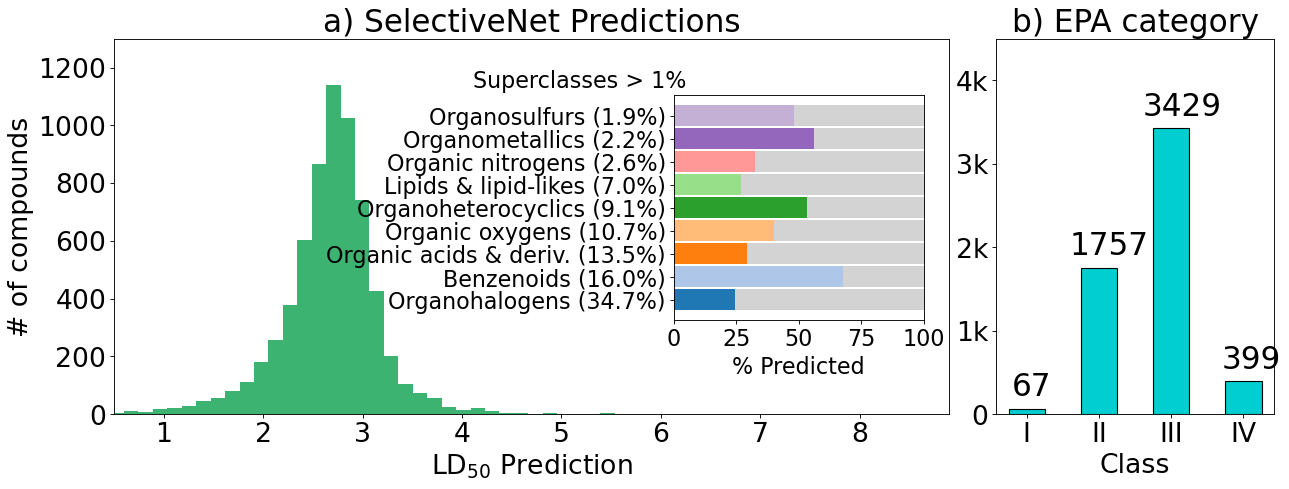

In [6]:
import matplotlib
import matplotlib.pyplot as plt

in_range = (-0.6986, 7.8262)

#merged = pfas8k_results.loc[pfas8k_results.fold==3]
merged = pfas8k_results.loc[~pfas8k_results.out_of_range].pivot_table(index=['smiles_y','superclass'], aggfunc=(lambda x: np.mean(x.dropna())))
merged['canon_smi'] = merged.index.get_level_values(0).values
merged['canon_smi'] = merged['canon_smi'].apply(Chem.MolFromSmiles).apply(Chem.MolToSmiles)
merged['superclass'] = merged.index.get_level_values(1)
merged['prediction_selected'] = merged['prediction_selected'] >= 0.5
merged['prediction_mgkg'] = list(converter.convert_to_mgkg(merged[['prediction_neglogld50']].values, merged[['canon_smi']].values))

merged.loc[merged.prediction_selected, 'prediction_epa'] = \
converter.convert_to_epa(merged.loc[merged.prediction_selected][['prediction_neglogld50']].values,
                         merged.loc[merged.prediction_selected][['canon_smi']].values).astype(np.float32)

merged = merged.loc[
    (((merged.prediction_neglogld50 >= in_range[0])
      & (merged.prediction_neglogld50 <= in_range[1])) | (merged.prediction_neglogld50.isna()))]

plt.rc('font', weight='normal', size=24, family='Arial')

plt.rcParams['figure.facecolor'] = 'white'

# Figure layout with custom sizing
fig = plt.figure(figsize=(16,6), dpi=80, facecolor='white', constrained_layout=True)
gs = fig.add_gridspec(1, 20)
ax = fig.add_subplot(gs[:,:15])
ax2 = fig.add_subplot(gs[:,15:])

# Histogram for plot (A)
ax.hist(merged['prediction_neglogld50'].dropna(), bins=50, color='mediumseagreen')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xlim((0.5,8.9))
ax.set_ylim(0,1300)
ax.set_xlabel('LD$_{50}$ Prediction')
ax.set_ylabel('# of compounds')
ax.set_title('a) SelectiveNet Predictions', fontsize=28)

# Percentage bars for plot (A) inset
axin = ax.inset_axes([0.67,0.25,0.3,0.6])
value_counts = merged['superclass'].value_counts(normalize=True)

cmap = plt.cm.tab20
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(value_counts)-1)

ind = 0

for (num, label), pct in zip(enumerate(value_counts[:9].index), value_counts[:9]*100):
    ind = ind+1
    
    if pct < 1:
        break

    predicted = len(merged.loc[(merged['superclass']==label) & (merged.prediction_selected)]) /\
        len(merged.loc[merged['superclass']==label])

    axin.barh(ind, predicted, 0.9, color = cmap(norm(num)))
    axin.barh(ind, (1-predicted), 0.9, left=predicted, color='lightgrey')

# Helper to shorten superclass category names
replace_with = [
    (' compounds', 's'),
    (' molecules', 's'),
    ('derivatives', 'deriv.'),
    ('and', '&')
]

def replace_all(text, needle_tuple):
    for i, j in needle_tuple:
        text = text.replace(i, j)
    return text

ticklabels = ['%s (%0.1f%%)' % (s,f) for s,f in zip(value_counts[:9].index.tolist(), value_counts[:9].values*100)]
ticklabels = [replace_all(label, replace_with) for label in ticklabels]

axin.set_yticks([1,2,3,4,5,6,7,8,9])
axin.set_yticklabels(ticklabels, fontsize=20)
axin.set_xlim((0,1))
axin.set_xticks([0,0.25,0.5,0.75,1])
axin.set_xticklabels([0,25,50,75,100], fontsize=20)
axin.set_xlabel('% Predicted', fontsize=20)
axin.text(-0.8, 10.2, 'Superclasses > 1%', fontsize=20)

# Barplot for plot (B)
levels_vc = merged['prediction_epa'].value_counts()
accepted = levels_vc.loc[0], levels_vc.loc[1], levels_vc.loc[2], levels_vc.loc[3]

ax2.bar(np.array([0,1,2,3])
        , accepted, width=0.5, label='All', color='darkturquoise',edgecolor='black')
ax2.set_xticks(np.array([0,1,2,3]))
ax2.set_xticklabels(['I', 'II', 'III', 'IV'])
ax2.set_xlabel('Class')
ax2.set_title('b) EPA category',fontsize=28)
ax2.set_ylim((0,4500))
ax2.set_yticks([0,1000,2000,3000,4000])
ax2.set_yticklabels(['0','1k','2k','3k','4k'])

for i, level in enumerate(['I', 'II', 'III', 'IV']):
    ax2.text(x=i-(0.1*len(str(accepted[i]))), y=accepted[i]+150, s=str(accepted[i]), fontsize=28)